<a href="https://colab.research.google.com/github/BranislavMajernik/zerocode/blob/master/MCLabelingD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
import gensim
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
from google.colab import files
uploaded = files.upload()

Saving npsFY21.csv to npsFY21.csv


In [7]:
df_train = pd.read_csv('npsFY21.csv')
df_train.head()

,ID,Comment,Type,Label
0,79171843,propose software that works correctly (see IFR...,Constructive,"Customer Care, Product"
1,80136748,"Support organisation very remote, hard to test...",Constructive,Support
2,81141131,Java has been working for years without any pr...,Positive,Product
3,81141886,do more publicity. We cannot compete with othe...,Constructive,Brand
4,81145926,"the manuals, about the different areas are unc...",Constructive,Enablement


Product                                  129
Cost                                      43
Support                                   42
Customer Care                             36
Enablement                                35
General                                   32
Ease of Use                               24
Product, Support                          14
Customer Care, Product                    11
Product - SaaS                            11
Commercial                                10
Ease of Use, Product                       7
Enablement, Product                        7
Brand                                      5
Cost, Support                              5
Cost, Product                              4
Ease of Use, Enablement                    3
Customer Care, Enablement                  3
Brand, Product                             2
Commercial, Cost                           2
Customer Care, Product, Support            2
Customer Care, Support                     2
Commercial

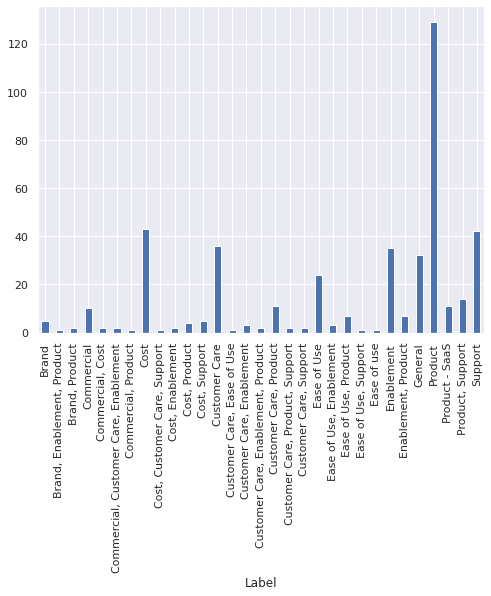

In [13]:
x=df_train['Label'].value_counts()
print(x)
# plot count of comment grouped by label
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df_train.groupby('Label').Comment.count().plot.bar(ylim=0)
plt.show()

In [12]:
# Missing data
df_train.isna().sum()

ID         0
Comment    0
Type       0
Label      0
dtype: int64

In [14]:
df_train.columns
from io import StringIO
col = ['Comment', 'Label']
df_train = df_train[col]
df_train = df_train[pd.notnull(df_train['Comment'])]
df_train.columns = ['Comment', 'Label']
df_train['Label']
df_train['category_id'] = df_train['Label'].factorize()[0]
category_id_df = df_train[['Label', 'category_id']].sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'Label']].values)
print(df_train)

                                               Comment  ... category_id
0    propose software that works correctly (see IFR...  ...           0
1    Support organisation very remote, hard to test...  ...           1
2    Java has been working for years without any pr...  ...           2
3    do more publicity. We cannot compete with othe...  ...           3
4    the manuals, about the different areas are unc...  ...           4
..                                                 ...  ...         ...
436        improve/increase service desk response time  ...           1
437  The feeling is that in the cloud services offe...  ...          14
438                                    improve support  ...           1
439  In the field of Oracle HCM Cloud, some modules...  ...          16
440         More responsive and better quality support  ...           1

[441 rows x 3 columns]


In [ ]:
#1. WORD-COUNT
number = 0
while number < 17 : 
  #1. WORD-COUNT
  df_train['word_count'] = df_train['Comment'].apply(lambda x: len(str(x).split()))
  print(df_train[df_train['category_id']==number]['word_count'].mean()) 
  number = number + 1

In [23]:
#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text=re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. 
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    
    return text

In [49]:
# Stopword
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)

# Initialize the stemmer
snow = SnowballStemmer('english')
def stemming(string):
    a=[snow.stem(i) for i in word_tokenize(string) ]
    return " ".join(a)

# Initialize the lemmatizer
wl = WordNetLemmatizer()
 
# This is a helper function to map NTLK position tags

def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [50]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

df_train['clean_text'] = df_train['Comment'].apply(lambda x: finalpreprocess(x))
#df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])
df_train.head()

,Comment,Label,category_id,word_count,clean_text,clean_text_tok
0,propose software that works correctly (see IFR...,"Customer Care, Product",0,14,propose software work correctly see ifrs asset...,"[propose, software, work, correctly, see, ifrs..."
1,"Support organisation very remote, hard to test...",Support,1,12,support organisation remote hard test product ...,"[support, organisation, remote, hard, test, pr..."
2,Java has been working for years without any pr...,Product,2,9,java work year without problem,"[java, work, year, without, problem]"
3,do more publicity. We cannot compete with othe...,Brand,3,17,publicity can not compete brand must make orac...,"[publicity, can, not, compete, brand, must, ma..."
4,"the manuals, about the different areas are unc...",Enablement,4,8,manual different area unclear,"[manual, different, area, unclear]"


In [29]:
# create Word2vec model
#here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
#length of words_f is number of documents/sentences in your dataset
df_train['clean_text_tok']=[nltk.word_tokenize(i) for i in df_train['clean_text']] #convert preprocessed sentence to tokenized sentence
model = Word2Vec(df_train['clean_text_tok'],min_count=1)  #min_count=1 means word should be present at least across all documents,
#if min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it


w2v = dict(zip(model.wv.index2word, model.wv.syn0))  #combination of word and its vector

#for converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


In [45]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND VALIDATION
 
# Input: "reviewText", "rating" and "time"
# Target: "log_votes"
X_train, X_val, y_train, y_val = train_test_split(df_train["clean_text"],
                                                  df_train["Label"],
                                                  test_size=0.1,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_val_tok= [nltk.word_tokenize(i) for i in X_val]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
# Only transform x_test (not fit and transform)
X_val_vectors_tfidf = tfidf_vectorizer.transform(X_val) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw.transform(X_train_tok)
X_val_vectors_w2v = modelw.transform(X_val_tok)

In [46]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)

lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')
lr_tfidf.fit(X_train_vectors_tfidf, y_train)  #model

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_val_vectors_tfidf)
y_prob = lr_tfidf.predict_proba(X_val_vectors_tfidf)[:,1]
 

#print(classification_report(y_val,y_predict))
#print('Confusion Matrix:',confusion_matrix(y_val, y_predict))
  

In [38]:
uploaded = files.upload()
dfo = pd.read_csv('npsFY22Q1.csv')
dfo.head()

Saving npsFY22Q1.csv to npsFY22Q1.csv


,ID,Comment
0,614588,sql
1,614823,Return of simple graphic database managers lik...
2,615036,valid product consolidated and always innovative
3,615271,Flexible price for services in Russia. Medium ...
4,615335,Performance


In [47]:
#Testing it on new dataset with the best model
df_test=pd.read_csv('npsFY22Q1.csv')  #reading the data
df_test['clean_text'] = df_test['Comment'].apply(lambda x: finalpreprocess(x)) #preprocess the data
X_test=df_test['clean_text'] 
X_vector=tfidf_vectorizer.transform(X_test) #converting X_test to vector
y_predict = lr_tfidf.predict(X_vector)      #use the trained model on X_vector
y_prob = lr_tfidf.predict_proba(X_vector)[:,1]
df_test['predict_prob']= y_prob
df_test['Label']= y_predict
print(df_test.head())
final=df_test[['ID','Comment', 'clean_text','Label']].reset_index(drop=True)
final.to_csv('Labeled.csv')


       ID  ...    Label
0  614588  ...  Product
1  614823  ...  Product
2  615036  ...  Product
3  615271  ...     Cost
4  615335  ...  Product

[5 rows x 5 columns]


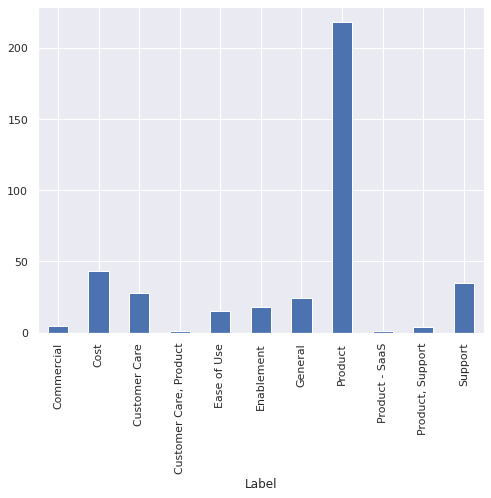

In [48]:
fig = plt.figure(figsize=(8,6))
df_test.groupby('Label').Comment.count().plot.bar(ylim=0)
plt.show()